# Bag of Words model for Rating Prediction from Text Review

In [1]:
import pandas as pd
import numpy as np
import time

import numpy as np
import re
import nltk
from sklearn.datasets import load_files
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
from nltk.corpus import stopwords

import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
import os
import glob

In [22]:
# if torch.cuda.is_available():
#     print('cuda available with GPU:',torch.cuda.get_device_name(0))
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")
device = torch.device("cpu")

## Loading data from csv file

In [3]:
seedly_df = pd.read_csv('data_seedly/seedly.csv')
seedly_df = seedly_df.replace({'ratings': {1: 100, 2: 200, 3:300, 4:400, 5:500}})
seedly_df = seedly_df.replace({'ratings': {100: 0, 200: 1, 300: 2, 400: 3, 500: 4}})

train_df = pd.read_csv('data_seedly/' + "train.tsv", sep='\t', names=['label', 'text'])
test_df = pd.read_csv('data_seedly/' + 'test.tsv', sep='\t', names=['label', 'text'])

In [4]:
seedly_df['text'] = seedly_df['text'].str.lower()
train_df['text'] = train_df['text'].str.lower()
test_df['text'] = test_df['text'].str.lower()
seedly_df.head()

,ratings,text
0,3,"no frills telco, but do give existing customer..."
1,4,application process the application process w...
2,3,impressive branding at the start. app has a gr...
3,3,"i haven’t started yet, and i really would have..."
4,4,2 years on circles.life and their customer sup...


In [5]:
X_train = train_df['text'].tolist()
y_train = train_df['label'].tolist()
X_test = test_df['text'].tolist()
y_test = test_df['label'].tolist()
X_all = X_train + X_test

from collections import Counter
print("The class distribution is: ", Counter(y_train))

The class distribution is:  Counter({4: 2758, 3: 974, 2: 291, 0: 255, 1: 104})


## Text preprocessing

In [6]:
documents = []

from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

def pre_processing(X):
    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)
        # Converting to Lowercase
        document = document.lower()
        # Lemmatization
        document = document.split()
        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)

        documents.append(document)
    return documents
documents = pre_processing(X_all)

## Importing all sklearn necessities

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## TF-IDF Vectorizer

In [8]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()
X.shape

(4930, 1500)

In [9]:
X_train = vectorizer.transform(X_train).toarray()
X_train = tfidfconverter.transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()
X_test = tfidfconverter.transform(X_test).toarray()

## Function definition to split data, fit classifier and show results

In [10]:
def run_sklearn_classifier(classifier, data_X_y):
    X_train, X_test, y_train, y_test = data_X_y
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # print("\n[R] Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
    # print("\n[R] Classification Report:\n", classification_report(y_test,y_pred))

    print("\n[R] The accuracy score for {} is: {}".format(str(classifier).split('(')[0], accuracy_score(y_test, y_pred)))

    df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred), index = [i for i in "12345"],
                      columns = [i for i in "12345"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap='gist_earth_r')

## Results for RandomForestClassifier

In [11]:
# clf_RF = RandomForestClassifier(n_estimators=1000, random_state=0)
# data_X_y = X_train, X_test, y_train, y_test
# run_sklearn_classifier(clf_RF, data_X_y)

## Results for LogisticRegressionClassifier


[R] The accuracy score for LogisticRegression is: 0.6514598540145985


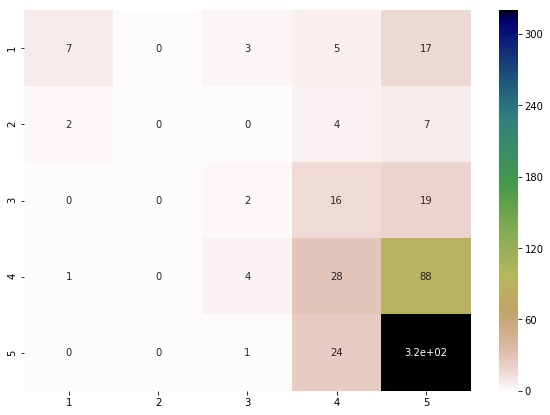

In [12]:
clf_LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
data_X_y = X_train, X_test, y_train, y_test
run_sklearn_classifier(clf_LR, data_X_y)

## Results for LinearSVM Classifier


[R] The accuracy score for LinearSVC is: 0.6459854014598541


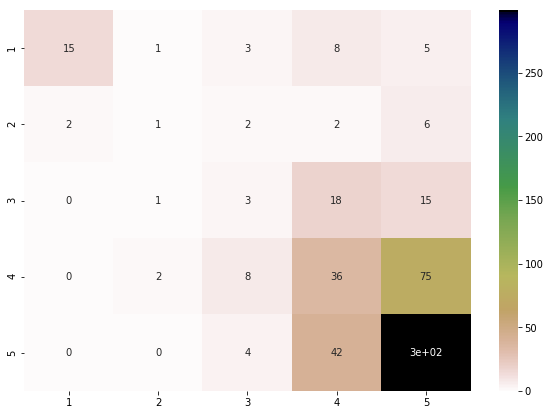

In [13]:
clf_SVM = LinearSVC(random_state=0, tol=1e-5)
data_X_y = X_train, X_test, y_train, y_test
run_sklearn_classifier(clf_SVM, data_X_y)

## MLP

In [14]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu1 = nn.ReLU()
        # self.fc2 = nn.Linear(hidden_size, hidden_size)
        # self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        # out = self.fc2(out)
        # out = self.relu2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

In [15]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64

x_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
train = TensorDataset(x_train, y_train)
train_loader = DataLoader(train, batch_size=batch_size)

x_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.long)
test = TensorDataset(x_test, y_test)
test_loader = DataLoader(test, batch_size=batch_size)

In [17]:
model = MLP(X.shape[1], 256, 5) 

In [18]:
loss_function = nn.CrossEntropyLoss()

def accuracy(scores, targets):
    scores = scores.detach().argmax(dim=1)
    acc = (scores==targets).float().sum().item()
    return acc

def train_epoch(model, optimizer, device, data_loader, epoch):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    
    for iter, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        
        batch_loss = loss.detach().item()
        epoch_loss += batch_loss
        epoch_acc += accuracy(output, target)
        nb_data += target.size(0)
        
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    
    return epoch_loss, epoch_acc, optimizer

def evaluate_network(model, device, data_loader, epoch):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    
    with torch.no_grad():
        for iter, (data, target) in enumerate(data_loader):
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = loss_function(output, target)
            batch_loss = loss.detach().item()
            
            epoch_loss += batch_loss
            epoch_acc += accuracy(output, target)
            nb_data += target.size(0)
            
        epoch_loss /= (iter + 1)
        epoch_acc /= nb_data
        
    return epoch_loss, epoch_acc

In [19]:
# ####################################################
# # Uncomment this code block, if you want to train
# ####################################################
# learning_rate = 1e-4

# print("MODEL DETAILS:\n")
# print(model)
# total_param = 0
# for param in model.parameters():
#     # print(param.data.size())
#     total_param += np.prod(list(param.data.size()))
# print('Total parameters:', total_param)

# t0 = time.time()
# per_epoch_time = []

# log_dir = 'out/logs/log_' + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')
# writer = SummaryWriter(log_dir=log_dir)

# model = MLP(X.shape[1], 256, 5) 
# model.to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# epoch_train_losses, epoch_test_losses = [], []
# epoch_train_accs, epoch_test_accs = [], []

# for epoch in range(20):
#     start = time.time()
#     epoch_train_loss, epoch_train_acc, optimizer = train_epoch(model, optimizer, device, train_loader, epoch)
#     epoch_test_loss, epoch_test_acc = evaluate_network(model, device, test_loader, epoch)

#     epoch_train_losses.append(epoch_train_loss)
#     epoch_test_losses.append(epoch_test_loss)
#     epoch_train_accs.append(epoch_train_acc)
#     epoch_test_accs.append(epoch_test_acc)

#     writer.add_scalar('train/_loss', epoch_train_loss, epoch)
#     writer.add_scalar('test/_loss', epoch_test_loss, epoch)
#     writer.add_scalar('train/_acc', epoch_train_acc, epoch)
#     writer.add_scalar('test/_acc', epoch_test_acc, epoch)
    

#     print("""Epoch {}, time {:.4f}s,
#              train_loss: {:.4f}, test_loss: {:.4f}, train_acc: {:.4f}, test_acc: {:.4f}""".format(epoch,
#                                         time.time()-start, epoch_train_loss, epoch_test_loss,
#                                         epoch_train_acc, epoch_test_acc))

#     per_epoch_time.append(time.time()-start)

#     # Saving checkpoint
#     ckpt_dir = 'out/ckpt'
#     if not os.path.exists(ckpt_dir):
#         os.makedirs(ckpt_dir)
#     torch.save(model.state_dict(), '{}.pkl'.format(ckpt_dir + "/epoch_" + str(epoch)))

#     files = glob.glob(ckpt_dir + '/*.pkl')
#     for file in files:
#         epoch_nb = file.split('_')[-1]
#         epoch_nb = int(epoch_nb.split('.')[0])
#         if epoch_nb < epoch-1:
#             os.remove(file)

# _, test_acc = evaluate_network(model, device, test_loader, epoch)

# print("Test Accuracy [LAST EPOCH]: {:.4f}".format(test_acc))
# print("TOTAL TIME TAKEN: {:.4f}hrs".format((time.time()-t0)/3600))
# print("AVG TIME PER EPOCH: {:.4f}s".format(np.mean(per_epoch_time)))

# writer.close()

In [20]:
def show_confusion_matrix(model, test_loader, nb_classes=5):
    nb_classes = 5

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    cm = np.array(confusion_matrix)
    confusion_matrix = cm.astype(int)
    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "12345"],
                      columns = [i for i in "12345"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap='gist_earth_r')

MLP MODEL DETAILS:

MLP(
  (fc1): Linear(in_features=1500, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=256, out_features=5, bias=True)
)
Total parameters: 385541

Test Accuracy of MLP model: 0.6624


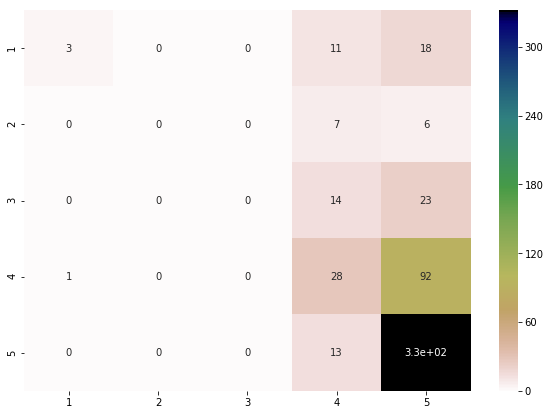

In [23]:
file_ckpt = 'mlp_epoch_19_best.pkl'

model = MLP(X.shape[1], 256, 5) 
model.load_state_dict(torch.load(file_ckpt))
_, test_acc = evaluate_network(model, device, test_loader, epoch=5)
print("MLP MODEL DETAILS:\n")
print(model)
total_param = 0
for param in model.parameters():
    # print(param.data.size())
    total_param += np.prod(list(param.data.size()))
print('Total parameters:', total_param)
print("\nTest Accuracy of MLP model: {:.4f}".format(test_acc))

show_confusion_matrix(model, test_loader)